In [4]:
import pandas as pd
import numpy as np
from pandas_datareader import data as wb
from datetime import datetime, timedelta
from statsmodels import regression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from scipy import stats
import finsymbols
%matplotlib inline
params = {'legend.fontsize': 'x-large','figure.figsize': (10, 5),'axes.labelsize': 'x-large','axes.titlesize':'x-large',
         'xtick.labelsize':'x-large','ytick.labelsize':'x-large'}#,'axes.facecolor': 'white'}
pylab.rcParams.update(params)

In [5]:
## Helper function to get prices from Yahoo
def get_historical_closes(ticker, start_date, end_date):
    # get the data for the tickers.  This will be a panel
    p = wb.DataReader(ticker, "yahoo", start_date, end_date)    
    # convert the panel to a DataFrame and selection only Adj Close
    # while making all index levels columns
    d = p.to_frame()['Adj Close'].reset_index()
    # rename the columns
    d.rename(columns={'minor': 'Ticker', 'Adj Close': 'Close'}, inplace=True)
    # pivot each ticker to a column
    pivoted = d.pivot(index='Date', columns='Ticker')
    # and drop the one level on the columns
    pivoted.columns = pivoted.columns.droplevel(0)
    return pivoted

### Collect Data

In [7]:
#define time period
start_date = '2015-10-31'
end_date = '2016-10-31'
#tickers = ['MSFT', 'AAPL', 'YHOO', 'FB', 'TSLA']
tickers = ['IBM','MSFT', 'AAPL', 'YHOO', 'FB', 'TSLA','A','AMG','AFL','AET','AES','AAP','ADBE','AYI','ATVI','ACN','ABBV','ABT','MMM','CVX','WFC']

#get data for stocks and benchmark
port = get_historical_closes(tickers, start_date=start_date, end_date=end_date).pct_change()[1:]
#bm = ret[['SPY']]
bm = port.mean(axis=1)
n = len(tickers)

# Create benchmark weights and identity matrix
bm_w =np.empty(n); bm_w.fill(1/n)
ones = np.ones(n)

### Calculate Beta

array([ 1.07436801,  0.83538668,  0.85456093,  0.85496859,  0.95705326,
        0.93548698,  1.11418932,  1.01870641,  0.93331059,  0.72157354,
        1.75092618,  1.11862188,  1.23980768,  0.96892442,  0.89925914,
        0.74103009,  0.59266538,  0.99721288,  1.28024953,  0.92618272,
        1.18551578])

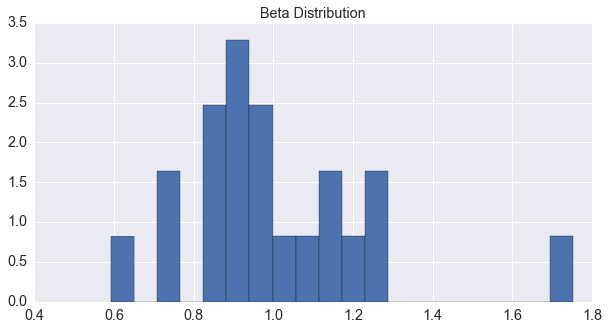

In [8]:
X = sm.add_constant(bm)             # add constant for intercept
y = port
model=sm.OLS(y, X)                  # regress using Benchmark as dependent
results = model.fit()


beta=results.params.iloc[1].values  # get all regresion coefficients
cov=(port.cov().values*252)
inv=np.linalg.inv(cov)
##
plt.hist(pd.Series(beta), bins=20, normed=True);
plt.title('Beta Distribution')
beta

### Generate Benchmark Neutral Alpha

In [9]:
# Create alpha from random, sorry, this is the hardest part of the process
# 
alpha=np.random.normal(0,0.05,n)
# create benchmark weight array
bm_a=alpha.dot(bm_w)

neu_alpha=[]
for i in range(0,n):
    #neu_alpha.append(beta[i])
    neu_alpha.append(alpha[i]-beta[i]*bm_a)
neu_alpha=np.asarray(neu_alpha)

In [10]:
neu_alpha

array([-0.03179847,  0.00596446, -0.02179605, -0.11345231, -0.01388394,
        0.08161736, -0.03076256, -0.01581203,  0.0071493 ,  0.02765382,
       -0.00714252,  0.0942388 ,  0.05996972, -0.0194608 , -0.01606961,
        0.02823062,  0.01043695,  0.0389923 , -0.05655553,  0.0293672 ,
       -0.05688673])

### Generate Benchmark Data

In [11]:
#create default benchmark equal weight:
bm_w =np.empty(n); bm_w.fill(1/n)

#create ones array
ones = np.ones(n)

#calculate benchmark Standard deviation
bm_stdev=(bm_w.T.dot(cov).dot(bm_w))**.5
bm_stdev

0.17019014192814733

### Generate unconstrained x from alpha 

In [12]:
# Generate unconstrained x vector
x_a=inv.dot(neu_alpha)/(abs(ones.dot(inv).dot(neu_alpha)))
x_a

# Gener
ret_a=x_a.dot(alpha)
risk_a=(x_a.dot(cov).dot(x_a))**.5
ir=ret_a/risk_a
print('Active Portfolio Return:', ret_a)
print('Active Portfolio Risk:', risk_a)
print('Information Ratio:',ir)
print('x alpha weights:',x_a)

Active Portfolio Return: 1.09614142318
Active Portfolio Risk: 1.03943379818
Information Ratio: 1.05455626429
x alpha weights: [-0.91285873 -0.1917264  -0.57116034 -1.68911469 -0.83562946  3.2771253
 -2.20144229 -0.1837884   0.56981471  1.32959447 -0.66200745  1.76645721
  1.32192596 -0.52381082 -1.15660701  0.6150033   0.02790708  0.97705938
 -0.27016974  1.63677945 -1.32335154]


### Generate X_e from VCV

In [13]:
# Generate x_e
x_e=inv.dot(ones)/ones.T.dot(inv).dot(ones)

#generate alpha_e and beta_e
beta_e=beta.dot(x_e)
alpha_e=neu_alpha.dot(x_e)


print('Beta of x_e portfolio:', beta_e)
print('Alpha of x_e portfolio:', alpha_e)
print('Exposure vector of x_e:',x_e)

Beta of x_e portfolio: 0.52772338978
Alpha of x_e portfolio: 0.0155077241053
Exposure vector of x_e: [ 0.03554881  0.08177416  0.09307598  0.04059654  0.04561951  0.05376135
 -0.06401914  0.01579924  0.046953    0.29419451 -0.24121701  0.00981092
 -0.02327452 -0.01046672  0.02902797  0.12531166  0.31484661  0.01363629
  0.03987579  0.09727605  0.00186902]


In [14]:
r_excess=0.06

### Generate Optimal Active Risk

Active Weights: [-0.05275551 -0.01758661 -0.04034759 -0.09716104 -0.04960088  0.18150011
 -0.11357105 -0.00925597  0.02954594  0.04287813 -0.00553242  0.10150762
  0.08037675 -0.02530443 -0.06573058  0.02273351 -0.03304077  0.05650657
 -0.01700696  0.08373982 -0.07189465]
Optimal Weights: [-0.00513646  0.03003244  0.00727146 -0.049542   -0.00198183  0.22911916
 -0.065952    0.03836308  0.07716499  0.09049718  0.04208663  0.14912667
  0.1279958   0.02231462 -0.01811153  0.07035256  0.01457828  0.10412561
  0.03061209  0.13135886 -0.0242756 ]
Total Portfolio Weight 1.0
Excess Return 0.06


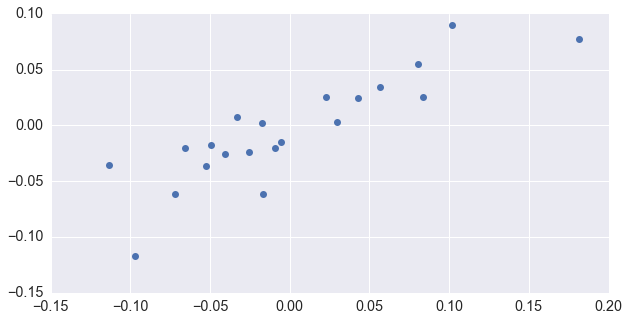

In [19]:
denom=(1-beta_e)*ret_a-alpha_e

#active portfolio
w_a=[]
for i in range(0,n):
    w_a.append(r_excess*((1-beta_e)*x_a[i]-x_e[i]+beta_e*bm_w[i])/denom)
w_a = np.array(w_a)

# calculate optimal portfolio
w_optimal = w_a+bm_w

print('Active Weights:', w_a)
print('Optimal Weights:', w_optimal)
print('Total Portfolio Weight',w_optimal.sum())
print('Excess Return',w_optimal.dot(neu_alpha).sum())

plt.plot(w_a, alpha, 'o')

,id,neu_alpha,w_a,w_optimal
6,ADBE,-0.030763,-0.113571,-0.065952
3,ABBV,-0.113452,-0.097161,-0.049542
20,YHOO,-0.056887,-0.071895,-0.024276
14,FB,-0.016070,-0.065731,-0.018112
0,A,-0.031798,-0.052756,-0.005136
4,ABT,-0.013884,-0.049601,-0.001982
2,AAPL,-0.021796,-0.040348,0.007271
16,MMM,0.010437,-0.033041,0.014578
13,CVX,-0.019461,-0.025304,0.022315
1,AAP,0.005964,-0.017587,0.030032


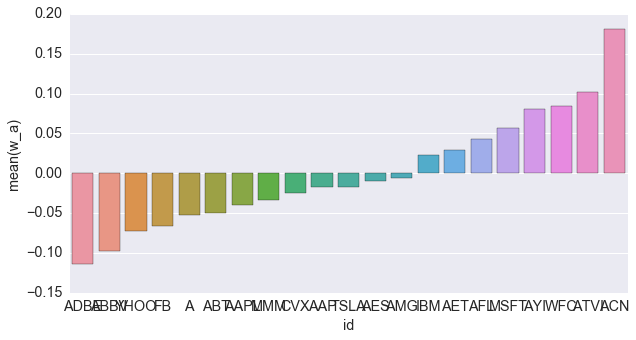

In [16]:
df_final=pd.DataFrame({'id': port.columns,
                       'neu_alpha': neu_alpha,
                       'w_a': w_a,
                       'w_optimal': w_optimal
                      })
df_final=df_final.sort_values(by='w_a')
ax = sns.barplot(x='id',y='w_a', data=df_final)
df_final